In [1]:
import sys
sys.path.append("../code/")
from sklearn.metrics import mean_absolute_error
from dataloader import APPLIANCE_ORDER, get_train_test
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable

cuda_av = False
if torch.cuda.is_available():
    cuda_av = True

torch.manual_seed(0)
np.random.seed(0)


weight_appliance = {'mw':1, 'dw':1, 'dr':1,'fridge':1, 'hvac':1}

# num_hidden, num_iterations, num_layers, p, num_directions = sys.argv[1:6]


class CustomRNN(nn.Module):
    def __init__(self):
        super(CustomRNN, self).__init__()
        torch.manual_seed(0)

      
        self.lin_1 = nn.Linear(24, 100)
        self.lin_2 = nn.Linear(100, 24)
        self.bn = nn.BatchNorm1d(100)
        #self.lin_3 = nn.Linear(48, 24)
        
        
        self.act_1 = nn.ReLU()
        self.act_2 = nn.ReLU()
        #self.act_3 = nn.ReLU()

    def forward(self, x):
        
        pred = self.lin_1(x)
        pred = self.act_1(pred)
        pred = self.bn(pred)
        pred = self.lin_2(pred)
        pred = self.act_2(pred)
        
        
        #pred = torch.clamp(pred, min=0.)
        #pred = self.act(pred)
        pred = torch.min(pred, x)
        return pred


class AppliancesRNN(nn.Module):
    def __init__(self, num_appliance):
        super(AppliancesRNN, self).__init__()
        self.num_appliance = num_appliance
        self.preds = {}
        self.order = ORDER
        for appliance in range(self.num_appliance):
            if cuda_av:
                setattr(self, "Appliance_" + str(appliance), CustomRNN().cuda())
            else:
                setattr(self, "Appliance_" + str(appliance), CustomRNN())

    def forward(self, *args):
        agg_current = args[0]
        flag = False
        if np.random.random() > args[1]:
            flag = True
        # print("Subtracting prediction")
        else:
            pass
        # print("Subtracting true")
        for appliance in range(self.num_appliance):
            # print(agg_current.mean().data[0])
            # print appliance
            # print self.order[appliance]
            # print args[2+appliance]
            #print(getattr(self, "Appliance_" + str(appliance)))
            self.preds[appliance] = getattr(self, "Appliance_" + str(appliance))(agg_current)
            if flag:
                agg_current = agg_current - self.preds[appliance]
            else:
                agg_current = agg_current - args[2 + appliance]

        return torch.cat([self.preds[a] for a in range(self.num_appliance)])

#ORDER = APPLIANCE_ORDER[1:][::-1]


num_hidden = 120
num_iterations = 300
num_layers = 1
num_directions = 1

input_dim = 1
hidden_size = num_hidden
num_layers = num_layers
if num_directions == 1:
    bidirectional = False
else:
    bidirectional = True
lr = 0.5
p = 0.1
num_folds = 5
fold_num = 0

torch.manual_seed(0)



In [2]:
aug_data = np.load('../aug_data_appliance.npy')

In [3]:
train, test = get_train_test(num_folds=num_folds, fold_num=fold_num)

In [4]:
num_aug = 50
train = np.vstack([train, aug_data[:num_aug]])

In [5]:
train_aggregate = train[:, 0, :, :].reshape(-1, 24)
test_aggregate = test[:, 0, :, :].reshape(-1, 24)

In [6]:
ORDER = APPLIANCE_ORDER[1:][:3]
ORDER = ['dw','fridge','dr','hvac']
#ORDER = ['fridge']
ORDER = ['hvac']

print (train.shape)

(104, 6, 112, 24)


In [7]:
out_train = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_train[a_num] = Variable(
        torch.Tensor(train[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((train_aggregate.shape[0], -1))))
    if cuda_av:
        out_train[a_num] = out_train[a_num].cuda()

out_test = [None for temp in range(len(ORDER))]
for a_num, appliance in enumerate(ORDER):
    out_test[a_num] = Variable(
        torch.Tensor(test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape((test_aggregate.shape[0], -1))))
    if cuda_av:
        out_test[a_num] = out_test[a_num].cuda()

loss_func = nn.L1Loss()
a = AppliancesRNN(num_appliance=len(ORDER))
#for param in a.parameters():
#    param.data = param.data.abs()
#print(a)
if cuda_av:
    a = a.cuda()
    loss_func = loss_func.cuda()
optimizer = torch.optim.Adam(a.parameters(), lr=lr)

In [8]:
inp = Variable(torch.Tensor(train_aggregate.reshape((train_aggregate.shape[0], -1))).type(torch.FloatTensor),
               requires_grad=True)

In [9]:
inp.size()

torch.Size([11648, 24])

In [10]:
for t in range(num_iterations):
    inp = Variable(torch.Tensor(train_aggregate), requires_grad=True)
    out = torch.cat([out_train[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
    ot =  torch.cat([out_test[appliance_num] for appliance_num, appliance in enumerate(ORDER)])
    if cuda_av:
        inp = inp.cuda()
        out = out.cuda()
        ot = ot.cuda()

    params = [inp, p]
    for a_num, appliance in enumerate(ORDER):
        params.append(out_train[a_num])
    # print(params)
    pred = a(*params)

    optimizer.zero_grad()
    pred_split = torch.split(pred, pred.size(0)//len(ORDER))

    losses= [loss_func(pred_split[appliance_num], out_train[appliance_num])*weight_appliance[appliance] for appliance_num, appliance in enumerate(ORDER)]
    
    loss = sum(losses)
    if t % 1 == 0:
        print(t, loss.data[0])

    loss.backward()
    optimizer.step()

(0, 870.9022827148438)
(1, 868.3705444335938)
(2, 850.6871948242188)
(3, 818.9712524414062)
(4, 764.2807006835938)
(5, 684.1810302734375)
(6, 582.8931884765625)
(7, 474.0671081542969)
(8, 367.33526611328125)
(9, 275.1098327636719)
(10, 208.36410522460938)
(11, 174.63934326171875)
(12, 165.36634826660156)
(13, 166.59042358398438)
(14, 169.74794006347656)
(15, 172.2734832763672)
(16, 173.8472900390625)
(17, 174.7525177001953)
(18, 175.1378631591797)
(19, 175.3018798828125)
(20, 175.3915557861328)
(21, 175.41932678222656)
(22, 175.39315795898438)
(23, 175.36383056640625)
(24, 175.36581420898438)
(25, 175.36412048339844)
(26, 175.32798767089844)
(27, 175.26895141601562)
(28, 175.17515563964844)
(29, 175.05279541015625)
(30, 174.9171600341797)
(31, 174.78562927246094)
(32, 174.62208557128906)
(33, 174.45021057128906)
(34, 174.26145935058594)
(35, 174.07916259765625)
(36, 173.9104461669922)
(37, 173.72802734375)
(38, 173.5377197265625)
(39, 173.33079528808594)
(40, 173.09666442871094)
(41, 1

In [11]:
params = list(a.parameters())

In [12]:
import seaborn as sns
sns.heatmap(params[0].data.numpy(),cmap='Greens')

In [13]:
pred.mean(dim=0)

Variable containing:
  767.8787
  679.1804
  593.6063
  536.8521
  505.1638
  500.2490
  407.5239
  329.9708
  415.2789
  503.7776
  650.6884
  845.0388
 1031.0276
 1245.6385
 1436.0037
 1609.1650
 1721.4832
 1761.7365
 1572.9579
 1490.0607
 1365.6045
 1216.0181
 1037.4904
  902.2043
[torch.FloatTensor of size 24]

In [14]:
test_inp = Variable(torch.Tensor(test_aggregate), requires_grad=False)
if cuda_av:
    test_inp = test_inp.cuda()

params = [test_inp, -2]
for i in range(len(ORDER)):
    params.append(None)
pr = a(*params)
pr = torch.clamp(pr, min=0.)
test_pred = torch.split(pr, test_aggregate.shape[0])
prediction_fold = [None for x in range(len(ORDER))]

if cuda_av:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].cpu().data.numpy().reshape(-1, 24)
else:
    for appliance_num, appliance in enumerate(ORDER):
        prediction_fold[appliance_num] = test_pred[appliance_num].data.numpy().reshape(-1, 24)
gt_fold = [None for x in range(len(ORDER))]
for appliance_num, appliance in enumerate(ORDER):
    gt_fold[appliance_num] = test[:, APPLIANCE_ORDER.index(appliance), :, :].reshape(test_aggregate.shape[0], -1,
                                                                                         1).reshape(-1, 24)

In [15]:
ORDER

['hvac']

In [16]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(prediction_fold[0], gt_fold[0])

125.80279694778379

In [17]:
prediction_fold[0].mean()

892.3822

In [18]:
%matplotlib inline

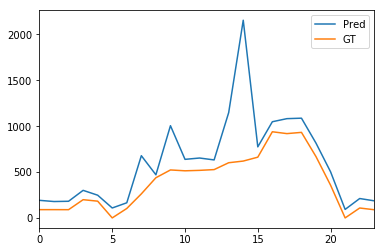

In [19]:
import matplotlib.pyplot as plt
pd.DataFrame(prediction_fold[0]).iloc[10].plot(label='Pred')
pd.DataFrame(gt_fold[0]).iloc[10].plot(label='GT')
plt.legend()

In [20]:



print([x.mean() for x in pred_split])
error = pd.Series({appliance:mean_absolute_error(gt_fold[appliance_num], prediction_fold[appliance_num]) for appliance_num, appliance in enumerate(ORDER)})

[Variable containing:
 963.5253
[torch.FloatTensor of size 1]
]
